# **Part 1:** Bias Tuning

## Import Libraries

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pyqtgraph as pg

from pyqtgraph.Qt import QtGui

import bias_tools as bt

from brian2 import ms, second, pA, nA, amp, farad, volt, prefs
from brian2 import SpikeMonitor, StateMonitor, SpikeGeneratorGroup

from teili.core.groups import Neurons, Connections
from teili import TeiliNetwork

from teili.models.neuron_models import DPI
from teili.models.synapse_models import DPISyn

from teili.models.parameters.dpi_neuron_param import parameters as neuron_model_param

from teili.tools.visualizer.DataControllers import Rasterplot, Lineplot
from teili.tools.visualizer.DataViewers import PlotSettings
from teili.tools.visualizer.DataModels import StateVariablesModel

In [45]:
# Target for code-generation
prefs.codegen.target = 'numpy'

## Set Up Simulation 

### Simulation Parameters

In [46]:
# NOTE: Flag for storing resulting paramters
store_params = False

# Topology
num_in = 1  # Number of virtual input neurons
num_ei = 1  # Number of E-I neurons

target_delay = 2  # (ms)
t_dur = 7  # Simulated time (ms)

# Time-constants
tau_i = 1e-3  # (s)
#tau_e = 1.5e-3  # (s)
tau_e = tau_i * 1.5

# Weights
w_e = 15e3
weights_e = np.arange(5, 50, 5) * 1e3
inh_factor = -1.4

### Define Input-Stimulus

In [47]:
i_in = np.arange(0, num_in)
t_in = np.zeros(num_in) * ms

spikegen_in = SpikeGeneratorGroup(num_in,
                                  indices = i_in,
                                  times = t_in)

### Define Network

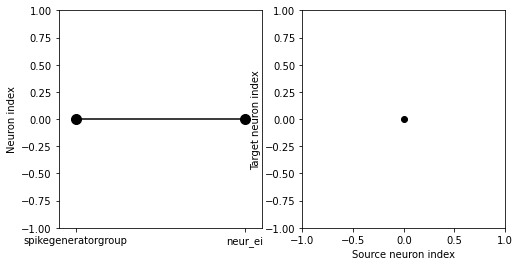

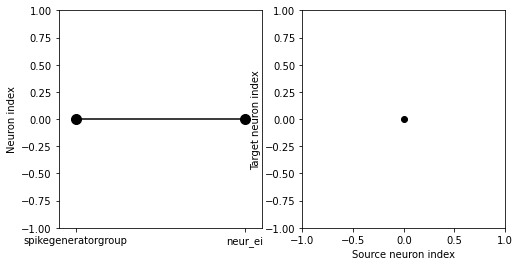

In [48]:
# E-I neurons
neur_ei = Neurons(N = num_ei, 
                  equation_builder = DPI(num_inputs = 2),
                  name = 'neur_ei')

# Excitatory synapses
syn_e = Connections(spikegen_in,
                    neur_ei,
                    equation_builder = DPISyn(),
                    name = 'syn_exc')

# Inhibitory synapses
syn_i = Connections(spikegen_in,
                    neur_ei,
                    equation_builder = DPISyn(),
                    name = 'syn_inh')

# Set connections
syn_e.connect(True)
syn_i.connect(True)

# Plot connections
syn_e.plot()
syn_i.plot()

# Neuron/synapse group names
group_names = ['neur_ei',
               'syn_e',
               'syn_i']

# Parameter-dictionary names
param_dict_names = ['params_ei',
                    'params_e',
                    'params_i']

# Get parameters
params_ei = neur_ei.get_params()
params_e = syn_e.get_params()
params_i = syn_i.get_params()

### Set Parameters

In [49]:
"""Neuronal parameters
"""
#neur_ei.Iconst = 1 * nA


"""Synaptic parameters
"""
# Weights
syn_e.weight = w_e
syn_i.weight = w_e * inh_factor

# Set current-values
syn_e.I_tau = bt.get_current(tau_e,
                             params_e['Csyn'] / farad,
                             params_e['Ut_syn'] / volt) * amp

syn_i.I_tau = bt.get_current(tau_i,
                             params_i['Csyn'] / farad,
                             params_i['Ut_syn'] / volt) * amp

# Synapse gain
#syn_e.I_th = syn_e.I_tau
#syn_i.I_th = syn_i.I_tau 

### Set Up Monitoring

In [50]:
"""Spike-monitors
"""
# Input spike-generator
spikemon_in = SpikeMonitor(spikegen_in)

# E-I neuron
spikemon_ei = SpikeMonitor(neur_ei)

"""State-monitors
"""
# Exc. synapse
statemon_e = StateMonitor(syn_e,
                          variables = 'I_syn',
                          record = True)
# Inh. synapse
statemon_i = StateMonitor(syn_i,
                          variables = 'I_syn',
                          record = True)
# E-I neuron
statemon_ei = StateMonitor(neur_ei,
                           variables = ['Iin', 'Imem', 'Iahp'],
                           record = [0])

## Run Simulation

In [51]:
# Initiate network
net = TeiliNetwork()

# Set up network
net.add(spikegen_in,
        neur_ei,
        syn_e, syn_i,
        spikemon_in, spikemon_ei,
        statemon_ei, statemon_e, statemon_i)

# Store initial network state
net.store('initialized')

q_e = np.array([])
q_i = np.array([])

for weight_e in weights_e:
        
        # Reset network state
        net.restore('initialized')

        # Set weights
        syn_e.weight = weight_e
        syn_i.weight = weight_e * inh_factor

        # Run simulation
        net.run(t_dur * ms)
        
        # Record "charge"
        q_e = np.append(q_e, statemon_e.I_syn[0].sum())
        q_i = np.append(q_i, statemon_i.I_syn[0].sum())
        
        

## Visualizations

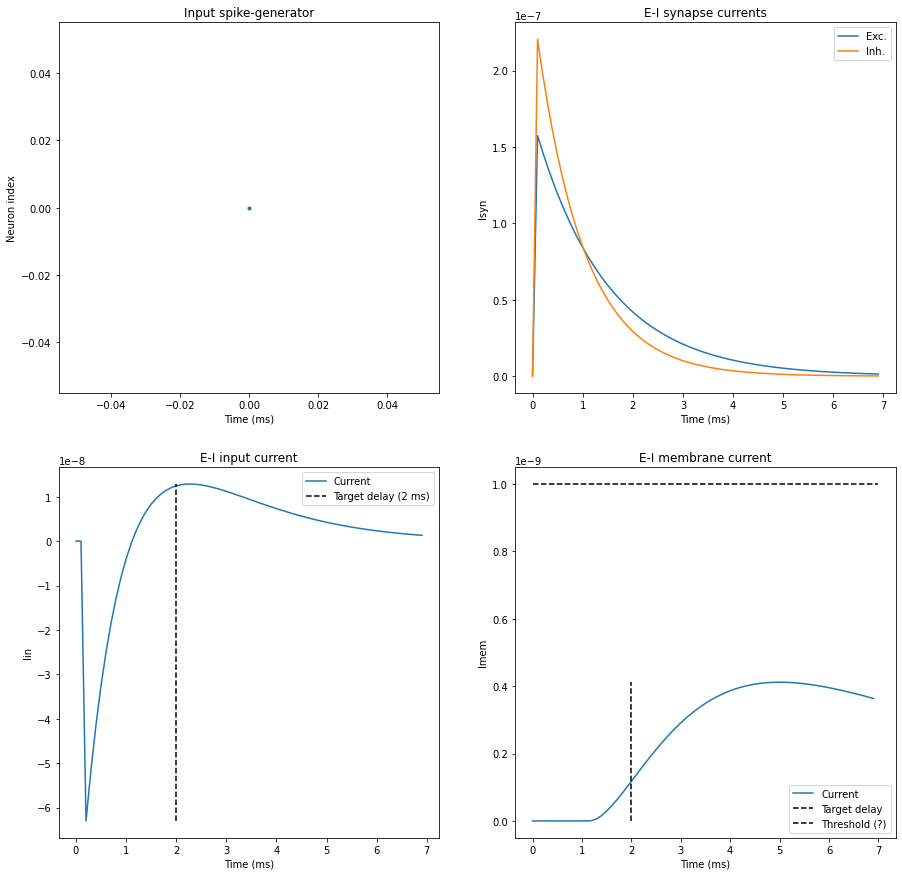

In [52]:
# Create figure for subplots
plt.figure(figsize = (15,15))

# Plot input spikes
plt.subplot(221)
plt.plot(spikemon_in.t/ms,
         spikemon_in.i,
         '.')
plt.title("Input spike-generator")
plt.xlabel("Time (ms)")
plt.ylabel("Neuron index")

# Plot synapse currents
plt.subplot(222)
plt.plot(statemon_e.t/ms, statemon_e.I_syn[0],
         statemon_i.t/ms, statemon_i.I_syn[0])
plt.title("E-I synapse currents")
plt.xlabel("Time (ms)")
plt.ylabel("Isyn")
plt.legend(["Exc.", "Inh."])

# Plot E-I input current
plt.subplot(223)
plt.plot(statemon_ei.t/ms, statemon_ei.Iin[0],
         [target_delay, target_delay],
         [statemon_ei.Iin[0].min(), statemon_ei.Iin[0].max()], 'k--')
plt.title("E-I input current")
plt.xlabel("Time (ms)")
plt.ylabel("Iin");
plt.legend(["Current", "Target delay (2 ms)"])

# Plot E-I membrane current
plt.subplot(224)
plt.plot(statemon_ei.t/ms, statemon_ei.Imem[0],
         [target_delay, target_delay],
         [statemon_ei.Imem[0].min(), statemon_ei.Imem[0].max()], 'k--',
         [0, t_dur],
         [params_ei['Ispkthr'], params_ei['Ispkthr']], 'k--')
plt.title("E-I membrane current")
plt.xlabel("Time (ms)")
plt.ylabel("Imem");
plt.legend(["Current", "Target delay", "Threshold (?)"])

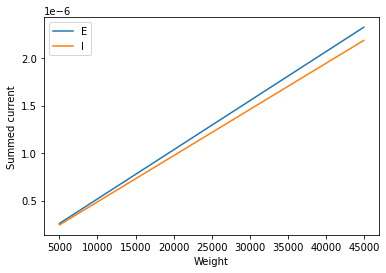

In [56]:
plt.figure()
plt.plot(weights_e, q_e,
         weights_e, q_i)

plt.xlabel("Weight")
plt.ylabel("Summed current")
plt.legend(["E", "I"])

## Store Parameters

In [54]:
if store_params:
    
    # Get parameters
    params_ei = neur_ei.get_params()
    params_e = syn_e.get_params()
    params_i = syn_i.get_params()

    # Extract first element of each parameter-array
    for param in params_ei:
        params_ei[param] = params_ei[param][0]

    for param in params_e:
        params_e[param] = params_e[param][0]
        
    for param in params_i:
        params_i[param] = params_i[param][0]

    # Loop over parameter sets
    for dict_name in param_dict_names:
        # Store parameters
        with open('Parameters/' + dict_name + '.pkl', 'wb') as file_out:
            pickle.dump(eval(dict_name), file_out)

In [55]:
tau_ei = bt.get_tau(params_ei['Itau'],
                    params_ei['Cmem'] / farad,
                    params_ei['Ut'] / volt) * amp

print(params_ei['Itau'])
print(tau_ei * second)

[8.] pA
[6.69642857] ms
